In [43]:
import numpy as np
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import json

from ipyleaflet import Map, Marker, DrawControl, basemaps, basemap_to_tiles, Heatmap
from ipywidgets import Layout
from random import uniform
from collections import Counter



In [44]:
# Downloaded from https://www.dropbox.com/s/r8ulqv2m6bs0ydd/keplergl%20%284%29.json?dl=0&fbclid=IwAR2VYS_SHZoqU2ssj5DcCGrGZckpMTL52etlblzFUxYkXv5Aacrf0qoHzUc
with open("delitos.json") as f:
    data = json.load(f)

Dado que el archivo viene como un json, lo convierto a Dataframe de pandas

In [45]:

# Convierto a pandas dataframe

rows = data['datasets'][0]['data']['allData']
fields = [e['name'].lower() for e in data['datasets'][0]['data']['fields']]

rows = [dict(zip(fields, r)) for r in rows]
for row in rows:
    row['timestamp'] = datetime.strptime(row['fecha del  hecho'], '%Y-%m-%d')

data = pd.DataFrame(rows)



In [46]:
data.head()

,mes,dia de la semana,fecha del hecho,franja 24 hs,hora del hecho,tipo de delito,cantidad de victimas,latitud,longitud,comuna,barrio,timestamp
0,Enero,Martes,2018-01-16,10.0,10:15:00,Hurto (Sin violencia),False,NaN,NaN,None,None,2018-01-16
1,Enero,Miercoles,2018-01-17,10.0,10:30:00,Hurto (Sin violencia),False,NaN,NaN,None,None,2018-01-17
2,Enero,Lunes,2018-01-01,9.0,09:45:00,Hurto (Sin violencia),False,NaN,NaN,None,None,2018-01-01
3,Enero,Viernes,2018-01-26,8.0,08:30:00,Hurto (Sin violencia),False,NaN,NaN,None,None,2018-01-26
4,Enero,Lunes,2018-01-22,9.0,09:00:00,Hurto (Sin violencia),False,NaN,NaN,None,None,2018-01-22


Veamos cuantos nulos tiene.

In [47]:
print(data.shape)
data.isna().sum()/data.shape[0] # la proporcion de nulos respecto del total de observaciones. 

(112791, 12)


mes                     0.000000
dia de la semana        0.000000
fecha del  hecho        0.000000
franja 24 hs            0.001383
hora del hecho          0.001383
tipo de delito          0.000000
cantidad de victimas    0.000000
latitud                 0.027502
longitud                0.027502
comuna                  0.026261
barrio                  0.026261
timestamp               0.000000
dtype: float64

Dado que la cantidad de nulos es poco representativa respecto del total de datos y  que mi objetivo es utilizar la ubicacion geografica para predecir delitos, voy a descartar todas las filas que contengan nulos, a modo de simplificar la tarea. 

In [48]:
data=data.dropna(axis=0,how="any")
data.head()

,mes,dia de la semana,fecha del hecho,franja 24 hs,hora del hecho,tipo de delito,cantidad de victimas,latitud,longitud,comuna,barrio,timestamp
490,Enero,Martes,2018-01-30,7.0,07:45:00,Hurto (Sin violencia),False,-34.622731,-58.391495,Comuna 1,CONSTITUCION,2018-01-30
491,Enero,Domingo,2018-01-07,4.0,04:15:00,Hurto Automotor,False,-34.622810,-58.391375,Comuna 1,CONSTITUCION,2018-01-07
492,Enero,Lunes,2018-01-22,12.0,12:20:00,Hurto (Sin violencia),False,-34.626330,-58.391249,Comuna 1,CONSTITUCION,2018-01-22
493,Enero,Martes,2018-01-23,8.0,08:30:00,Hurto (Sin violencia),False,-34.634121,-58.390359,Comuna 1,CONSTITUCION,2018-01-23
494,Enero,Lunes,2018-01-01,23.0,23:15:00,Hurto (Sin violencia),False,-34.634121,-58.390359,Comuna 1,CONSTITUCION,2018-01-01


Veamos que hay en la columna cantidad de victimas.

In [49]:
data['cantidad de victimas'].value_counts() # es probable que en cantidad de victimas haga referencia a las muertes

False    109420
True        116
Name: cantidad de victimas, dtype: int64

In [50]:
data['tipo de delito'].value_counts() # si bien, los valores son similares no concuerdan en su totalidad, veamos si al menos la mayoria coincide con homicidios dolosos

Robo (Con violencia)     66018
Hurto (Sin violencia)    35023
Hurto Automotor           5677
Robo Automotor            2699
Homicidio Doloso           119
Name: tipo de delito, dtype: int64

Aparentemente la columna cantidad de victimas corresponde a victimas fatales, aunque es posible que en su mayoria sean homicidio doloso y las restantes a algun otro tipo de muerte. 

In [51]:
doloso_mask =data['tipo de delito']=='Homicidio Doloso'
data_homicidio_doloso = data[doloso_mask]  
data_homicidio_doloso.sample(10)

,mes,dia de la semana,fecha del hecho,franja 24 hs,hora del hecho,tipo de delito,cantidad de victimas,latitud,longitud,comuna,barrio,timestamp
28371,Abril,Jueves,2018-04-12,5.0,05:50:00,Homicidio Doloso,True,-34.624787,-58.383070,Comuna 1,CONSTITUCION,2018-04-12
89493,Octubre,Miercoles,2018-10-24,6.0,06:15:00,Homicidio Doloso,True,-34.673819,-58.464347,Comuna 8,VILLA LUGANO,2018-10-24
100844,Noviembre,Miercoles,2018-11-28,21.0,21:40:00,Homicidio Doloso,True,-34.601267,-58.523744,Comuna 11,VILLA DEVOTO,2018-11-28
10162,Febrero,Lunes,2018-02-12,1.0,01:00:00,Homicidio Doloso,True,-34.602453,-58.379545,Comuna 1,SAN NICOLAS,2018-02-12
55605,Julio,Domingo,2018-07-22,4.0,04:00:00,Homicidio Doloso,True,-34.625839,-58.382594,Comuna 1,CONSTITUCION,2018-07-22
67835,Agosto,Domingo,2018-08-12,2.0,02:10:00,Homicidio Doloso,True,-34.648585,-58.409075,Comuna 4,NUEVA POMPEYA,2018-08-12
40135,Mayo,Miercoles,2018-05-16,7.0,07:28:00,Homicidio Doloso,True,-34.651921,-58.392806,Comuna 4,BARRACAS,2018-05-16
1640,Enero,Jueves,2018-01-18,9.0,09:15:00,Homicidio Doloso,True,-34.585225,-58.380041,Comuna 1,RETIRO,2018-01-18
88881,Octubre,Miercoles,2018-10-10,21.0,21:15:00,Homicidio Doloso,True,-34.628516,-58.469167,Comuna 7,FLORES,2018-10-10
37995,Mayo,Viernes,2018-05-04,0.0,00:30:00,Homicidio Doloso,True,-34.605648,-58.387311,Comuna 1,SAN NICOLAS,2018-05-04


Veamos si esto es correcto

In [52]:
doloso_igual_victim_mask = doloso_mask == data['cantidad de victimas'] 
data[doloso_igual_victim_mask == False]

,mes,dia de la semana,fecha del hecho,franja 24 hs,hora del hecho,tipo de delito,cantidad de victimas,latitud,longitud,comuna,barrio,timestamp
7280,Enero,Domingo,2018-01-14,20.0,20:00:00,Homicidio Doloso,False,-34.569464,-58.505272,Comuna 12,VILLA URQUIZA,2018-01-14
19293,Marzo,Viernes,2018-03-09,4.0,04:15:00,Homicidio Doloso,False,-34.584441,-58.375672,Comuna 1,RETIRO,2018-03-09
53923,Junio,Lunes,2018-06-04,22.0,22:30:00,Homicidio Doloso,False,-34.556994,-58.460646,Comuna 13,BELGRANO,2018-06-04


Si bien es posible que no correspondan a otro tipo de muerte, me inclino a que corresponde a un homicidio doloso por lo cual voy a pasar a True esos valores

In [53]:
data.loc[doloso_igual_victim_mask == False,'cantidad de victimas'] = True

Verifiquemos que lo realizamos correctamente

In [54]:
data.loc[doloso_igual_victim_mask == False,'cantidad de victimas']

7280     True
19293    True
53923    True
Name: cantidad de victimas, dtype: bool

In [55]:
data.rename(columns = {'cantidad de victimas':'victimas fatales'}, inplace=True)

In [56]:
data.head()

,mes,dia de la semana,fecha del hecho,franja 24 hs,hora del hecho,tipo de delito,victimas fatales,latitud,longitud,comuna,barrio,timestamp
490,Enero,Martes,2018-01-30,7.0,07:45:00,Hurto (Sin violencia),False,-34.622731,-58.391495,Comuna 1,CONSTITUCION,2018-01-30
491,Enero,Domingo,2018-01-07,4.0,04:15:00,Hurto Automotor,False,-34.622810,-58.391375,Comuna 1,CONSTITUCION,2018-01-07
492,Enero,Lunes,2018-01-22,12.0,12:20:00,Hurto (Sin violencia),False,-34.626330,-58.391249,Comuna 1,CONSTITUCION,2018-01-22
493,Enero,Martes,2018-01-23,8.0,08:30:00,Hurto (Sin violencia),False,-34.634121,-58.390359,Comuna 1,CONSTITUCION,2018-01-23
494,Enero,Lunes,2018-01-01,23.0,23:15:00,Hurto (Sin violencia),False,-34.634121,-58.390359,Comuna 1,CONSTITUCION,2018-01-01


In [57]:
def CreateDummies(data,var_name):
    dummy= pd.get_dummies(data[var_name],prefix=var_name)
    data=data.drop(var_name,axis=1)
    data=pd.concat([data,dummy],axis=1)
    return data

In [58]:
dummy_data=CreateDummies(data,"tipo de delito")

dummy_data.head()

,mes,dia de la semana,fecha del hecho,franja 24 hs,hora del hecho,victimas fatales,latitud,longitud,comuna,barrio,timestamp,tipo de delito_Homicidio Doloso,tipo de delito_Hurto (Sin violencia),tipo de delito_Hurto Automotor,tipo de delito_Robo (Con violencia),tipo de delito_Robo Automotor
490,Enero,Martes,2018-01-30,7.0,07:45:00,False,-34.622731,-58.391495,Comuna 1,CONSTITUCION,2018-01-30,0,1,0,0,0
491,Enero,Domingo,2018-01-07,4.0,04:15:00,False,-34.622810,-58.391375,Comuna 1,CONSTITUCION,2018-01-07,0,0,1,0,0
492,Enero,Lunes,2018-01-22,12.0,12:20:00,False,-34.626330,-58.391249,Comuna 1,CONSTITUCION,2018-01-22,0,1,0,0,0
493,Enero,Martes,2018-01-23,8.0,08:30:00,False,-34.634121,-58.390359,Comuna 1,CONSTITUCION,2018-01-23,0,1,0,0,0
494,Enero,Lunes,2018-01-01,23.0,23:15:00,False,-34.634121,-58.390359,Comuna 1,CONSTITUCION,2018-01-01,0,1,0,0,0


In [59]:
delitos_por_dia=data.groupby(["dia de la semana","tipo de delito"])
data_delitos=CreateDummies(data,"tipo de delito")

In [60]:
#delitos_por_dia.size()
data_delitos.head(10)

,mes,dia de la semana,fecha del hecho,franja 24 hs,hora del hecho,victimas fatales,latitud,longitud,comuna,barrio,timestamp,tipo de delito_Homicidio Doloso,tipo de delito_Hurto (Sin violencia),tipo de delito_Hurto Automotor,tipo de delito_Robo (Con violencia),tipo de delito_Robo Automotor
490,Enero,Martes,2018-01-30,7.0,07:45:00,False,-34.622731,-58.391495,Comuna 1,CONSTITUCION,2018-01-30,0,1,0,0,0
491,Enero,Domingo,2018-01-07,4.0,04:15:00,False,-34.622810,-58.391375,Comuna 1,CONSTITUCION,2018-01-07,0,0,1,0,0
492,Enero,Lunes,2018-01-22,12.0,12:20:00,False,-34.626330,-58.391249,Comuna 1,CONSTITUCION,2018-01-22,0,1,0,0,0
493,Enero,Martes,2018-01-23,8.0,08:30:00,False,-34.634121,-58.390359,Comuna 1,CONSTITUCION,2018-01-23,0,1,0,0,0
494,Enero,Lunes,2018-01-01,23.0,23:15:00,False,-34.634121,-58.390359,Comuna 1,CONSTITUCION,2018-01-01,0,1,0,0,0
495,Enero,Sábado,2018-01-20,18.0,18:30:00,False,-34.618439,-58.390357,Comuna 1,CONSTITUCION,2018-01-20,0,0,1,0,0
496,Enero,Viernes,2018-01-19,12.0,12:00:00,False,-34.623958,-58.390071,Comuna 1,CONSTITUCION,2018-01-19,0,1,0,0,0
497,Enero,Lunes,2018-01-29,23.0,23:30:00,False,-34.623958,-58.390071,Comuna 1,CONSTITUCION,2018-01-29,0,0,1,0,0
498,Enero,Martes,2018-01-02,23.0,23:15:00,False,-34.620054,-58.389579,Comuna 1,CONSTITUCION,2018-01-02,0,1,0,0,0
499,Enero,Jueves,2018-01-25,2.0,02:00:00,False,-34.618948,-58.389428,Comuna 1,CONSTITUCION,2018-01-25,0,0,1,0,0


Veamos como varia el porcentaje de crimenes respecto del dia de la semana, para cada tipo de delito

Text(0.5, 1.0, 'Tipos de crimenes vs dia de la semana')

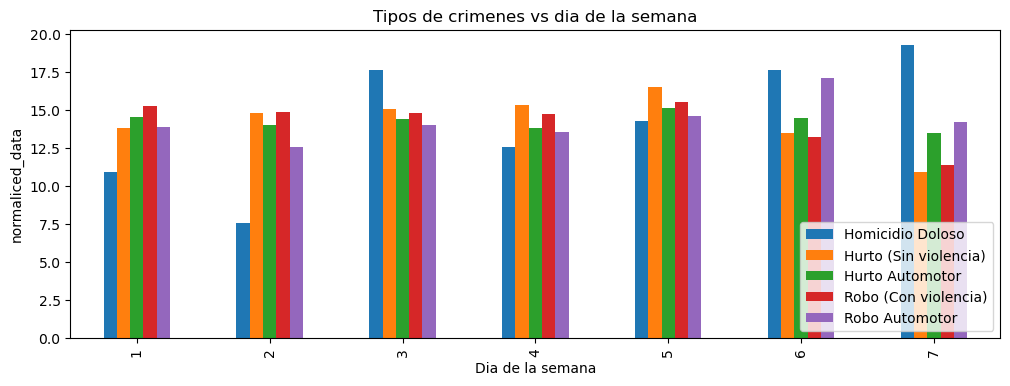

In [61]:
data['Dia de la semana'] = data.timestamp.apply(lambda x: x.isoweekday()) # sustituyo dias de la semana por su contraparte numerica en una nueva columna

a = data.pivot_table(index='Dia de la semana', columns='tipo de delito', values=[], aggfunc=len) # genero una pivot table de acuerdo a los tipos de delito vs dias de semana
normaliced_data = a.divide(a.sum(0), axis=1) * 100 # normalizo la data respecto del total de observaciones para cada dia luego multiplico por 100 para obtener el porcentaje

normaliced_data.plot(kind='bar',figsize=(12,4))
plt.legend(loc='lower right')
plt.ylabel('normaliced_data')
plt.title('Tipos de crimenes vs dia de la semana')


## Distribucion geografica de los crimenes

Para poder observar la distribucion de los crimenes de una manera razonable, voy a generar de manera arbitraria una categorizacion ordinaria sobre los tipos de crimenes.
Mas claramente, voy a decir que algunos crimenes son peores de acuerdo a la violencia y el coste material. (Tiene sus falencias)

La idea de ésto, es agregarle peso a crimenes mas violentos. con el objetivo de que zonas con crimenes mas violentos destaquen mas. 

In [62]:
data.head()

,mes,dia de la semana,fecha del hecho,franja 24 hs,hora del hecho,tipo de delito,victimas fatales,latitud,longitud,comuna,barrio,timestamp,Dia de la semana
490,Enero,Martes,2018-01-30,7.0,07:45:00,Hurto (Sin violencia),False,-34.622731,-58.391495,Comuna 1,CONSTITUCION,2018-01-30,2
491,Enero,Domingo,2018-01-07,4.0,04:15:00,Hurto Automotor,False,-34.622810,-58.391375,Comuna 1,CONSTITUCION,2018-01-07,7
492,Enero,Lunes,2018-01-22,12.0,12:20:00,Hurto (Sin violencia),False,-34.626330,-58.391249,Comuna 1,CONSTITUCION,2018-01-22,1
493,Enero,Martes,2018-01-23,8.0,08:30:00,Hurto (Sin violencia),False,-34.634121,-58.390359,Comuna 1,CONSTITUCION,2018-01-23,2
494,Enero,Lunes,2018-01-01,23.0,23:15:00,Hurto (Sin violencia),False,-34.634121,-58.390359,Comuna 1,CONSTITUCION,2018-01-01,1


Voy a mapear de acuerdo al siguiente diccionario:

In [63]:
map_dic = {'Homicidio Doloso':5,
           'Robo (Con violencia)':4,
           'Robo Automotor':3,
           'Hurto Automotor':2,
           'Hurto (Sin violencia)':1}

Detalle importante, debe comenzar con 1 ya que voy a usar esa categorizacion como peso al realizart el heatmap

In [64]:
data['tipo de delito numerico'] = data['tipo de delito'].map(map_dic)

In [65]:
data['tipo de delito numerico'].unique() # vamos que no quedaron observaciones con nans

array([1, 2, 5, 4, 3])

### Mapa de calor interactivo utilizando ipyleaflet

Uso la libreria para generar un heatmap de capital federal con los crimenes y su ubicacion geografica. En una primera instancia le agrego a todos los crimenes el mismo peso

In [66]:
m = Map(center=(-34.586546, -58.39825), zoom=13) # inicializo el mapa

data_heatmap_2 = data[["latitud","longitud"]]# # Necesita que le pase una lista con lat, lon y la intensidad del punto
data_heatmap_2.loc[~data_heatmap_2.latitud.isnull(),'uniform'] = np.ones(data_heatmap_2.shape[0])

data_heatmap_2 = data_heatmap_2.to_numpy().tolist()
heatmap = Heatmap(
    locations = data_heatmap_2 ,
    min_opacity=0.05,
    max=2, # 1 para mas placerrrr
    blur=15,
    radius=10
)

m.add_layer(heatmap);

m


/tmp/ipykernel_320362/4148134753.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_heatmap_2.loc[~data_heatmap_2.latitud.isnull(),'uniform'] = np.ones(data_heatmap_2.shape[0])


Map(center=[-34.586546, -58.39825], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

Repito lo anterior, pero haciendo uso de los pesos sobre cada crimen que genere en la etapa previa. 

In [67]:

m = Map(center=(-34.586546, -58.39825), zoom=13) # inicializo el mapa

data_heatmap = data[["latitud","longitud","tipo de delito numerico"]].to_numpy().tolist() # Necesita que le pase una lista con lat, lon y la intensidad del punto

heatmap = Heatmap(
    locations = data_heatmap ,
    min_opacity=0.05,
    max=7, # 1 para mas placerrrr
    blur=15,
    radius=10,
    layout=Layout(width='600px', height='300px')
)

m.add_layer(heatmap);

m


Map(center=[-34.586546, -58.39825], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

Veamos como cambia si le asigno a todos los crimenes el mismo peso.

Para futuras iteraciones de este mapa y con el objetivo de comparar mejor, seria bueno normalizar de alguna manera los datos para que   